In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
!unzip pizza_steak_sushi.zip

Archive:  pizza_steak_sushi.zip
  inflating: pizza_steak_sushi/test/steak/296375.jpg  
  inflating: pizza_steak_sushi/test/steak/673127.jpg  
  inflating: pizza_steak_sushi/test/steak/894825.jpg  
  inflating: pizza_steak_sushi/test/steak/1868005.jpg  
  inflating: pizza_steak_sushi/test/steak/27415.jpg  
  inflating: pizza_steak_sushi/test/steak/1016217.jpg  
  inflating: pizza_steak_sushi/test/steak/1285886.jpg  
  inflating: pizza_steak_sushi/test/steak/502076.jpg  
  inflating: pizza_steak_sushi/test/steak/3424937.jpg  
  inflating: pizza_steak_sushi/test/steak/690177.jpg  
  inflating: pizza_steak_sushi/test/steak/354513.jpg  
  inflating: pizza_steak_sushi/test/steak/2117351.jpg  
  inflating: pizza_steak_sushi/test/steak/100274.jpg  
  inflating: pizza_steak_sushi/test/steak/2144308.jpg  
  inflating: pizza_steak_sushi/test/steak/966174.jpg  
  inflating: pizza_steak_sushi/test/steak/1882831.jpg  
  inflating: pizza_steak_sushi/test/steak/3873283.jpg  
  inflating: pizza_steak_s

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

In [49]:
# Data augmentation
data_transforms = {
    'train': transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]),
    'test': transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
}

In [56]:
data_dir = '/content/pizza_steak_sushi'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes
print(class_names)
dataset_sizes

['pizza', 'steak', 'sushi']


{'train': 225, 'test': 75}

In [55]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.axis('off')
    plt.show()

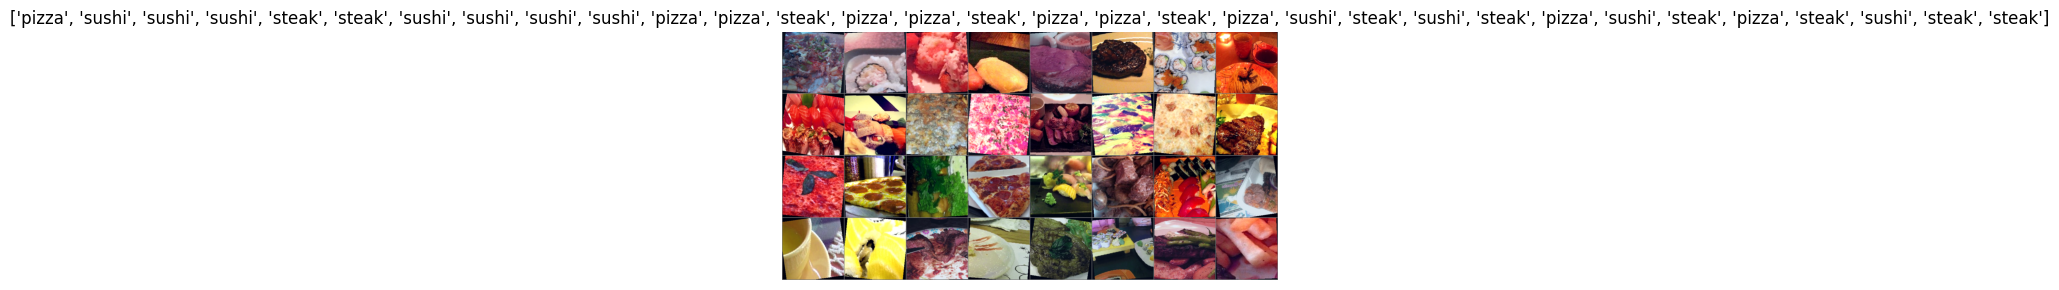

In [57]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [24]:
import torch.nn.functional as F

class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 5)
        self.conv3 = nn.Conv2d(128, 256, 5)

        self.fc1 = nn.Linear(256 * 576, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
net = NeuralNet()

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [27]:
from tqdm import tqdm

EPOCHS = 2
print("Training...")
for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(tqdm(dataloaders['train'], desc=f"Epoch {epoch + 1} of {EPOCHS}", leave=True, ncols=80)):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

Training...


Epoch 2 of 2: 100%|█████████████████████████████| 23/23 [02:34<00:00,  6.73s/it]


In [32]:
# Model Accuracy
correct_pred = 0
total_pred = 0
with torch.no_grad():
  for (images, labels) in dataloaders['test']:
    outputs = net(images)
    prob, predictions = torch.max(outputs, 1)
    for label, prediction in zip(labels, predictions):
            if label == prediction:
              correct_pred += 1
            total_pred += 1
acc = (correct_pred/total_pred) * 100
print(f'Test Accuracy: {acc:.1f}%')

Test Accuracy: 40.0%


In [68]:
# Transfer Learning
model = models.resnet101(pretrained=True)
num_flts = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_flts, 3)
)

for param in model.parameters():
    param.requires_grad = False
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 104MB/s]


In [69]:
num_epochs = 5
for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  correct_train = 0
  total_train = 0
  for inputs, labels in tqdm(dataloaders['train'], desc=f"Epoch {epoch + 1}/{num_epochs}", leave=True, ncols=80):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Compute training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        running_loss += loss.item()

  # Print training loss and accuracy
  train_loss = running_loss / len(dataloaders['train'])
  train_accuracy = 100 * correct_train / total_train
  print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
  # Validation (Test) phase
  model.eval()  # Set model to evaluation mode
  correct_test = 0
  total_test = 0
  with torch.no_grad():
      for inputs, labels in dataloaders['test']:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          _, predicted = torch.max(outputs, 1)
          total_test += labels.size(0)
          correct_test += (predicted == labels).sum().item()

  # Print test accuracy
  test_accuracy = 100 * correct_test / total_test
  print(f"Test Accuracy: {test_accuracy:.2f}%")
print('Finished Training')

Epoch 1/5: 100%|██████████████████████████████████| 8/8 [00:03<00:00,  2.21it/s]


Train Loss: 0.6256, Train Accuracy: 72.89%
Test Accuracy: 52.00%


Epoch 2/5: 100%|██████████████████████████████████| 8/8 [00:03<00:00,  2.22it/s]


Train Loss: 0.4577, Train Accuracy: 83.11%
Test Accuracy: 25.33%


Epoch 3/5: 100%|██████████████████████████████████| 8/8 [00:04<00:00,  1.99it/s]


Train Loss: 0.2647, Train Accuracy: 88.89%
Test Accuracy: 80.00%


Epoch 4/5: 100%|██████████████████████████████████| 8/8 [00:03<00:00,  2.22it/s]


Train Loss: 0.2412, Train Accuracy: 89.33%
Test Accuracy: 88.00%


Epoch 5/5: 100%|██████████████████████████████████| 8/8 [00:03<00:00,  2.01it/s]


Train Loss: 0.1996, Train Accuracy: 92.44%
Test Accuracy: 90.67%
Finished Training


In [71]:
file = 'model.pth'
torch.save(model, file)